# Animation

Animations can be an effective way to show an extra dimension of your data, especially changes over time. Clearly, they're not appropriate everywhere, eg in static media! For various reasons, they should be used sparingly, but-used rarely and with care-they can convey a message about data more effectively than a static chart ever would. Perhaps the most famous example of an animated chart is the legendary Hans Roslings' [gapminder animation](https://youtu.be/jbkSRLYSojo?t=29) covering 200 countries and 200 years of progress in income and health.

The most common scenario for wanting to create an animation is sharing on social media (gifs are ubiquitous on the internet) or displaying an animation of some of your results during a talk. In both these cases, creating a gif is probably the best and safest option. 'The best' because although video files tend to be very large (and thus difficult to share), gifs can be turned into small files, with a bit of tweaking. 'The safest' because even though presentation software like Microsoft's Powerpoint can crumble when trying to play an embedded video file, gifs usually work just fine. And while video formats differ across operating systems, all of them will play gifs (all you need to play a gif is a browser such as Safari or Chrome).  However, you can also create animations in other video formats, such as .mp4. The main downside of gifs is that they can produce quite jerky videos.

There are several ways to produce animations in Python, which we'll come to in a moment. First though, let's import some of the general packages we'll need: 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Settings
# Set max rows displayed for readability
pd.set_option('display.max_rows', 6)
# Plot settings
plt.style.use("https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt")

## Plot To Animate 

First, we need a plot to animate. And what better dataset than the gapminder data? "There is none!" I hear you shout at your computer. But hang on, perhaps we'd better see a simple demonstration of some of the principles we'll be using first.

A video is a sequence of static images stitched together and replayed quickly, like a flickbook cartoon. We will use the same trick, a series of static images played after one another, to create animated charts. But this means we need to create the series of static images.

Let's create individual images and index them with $i$. We want to move on to a new scene every time we increment $i$. We do this by creating a *function* that accepts $i$ as a parameter and that modifies what is shown on the image. The below example shows how it can work: although the $x$ and $y$ arrays are always defined, and an $x$-$y$ line plot is always shown, the `ax.scatter` function is passed only the $i$th element of the $x$ and $y$ arrays. When we call `plot_scene` with different values of $i$, the scene updates to the next moment in time. In the example below, the bead moves along 1/20th of its journey between 0 and $2\pi$.


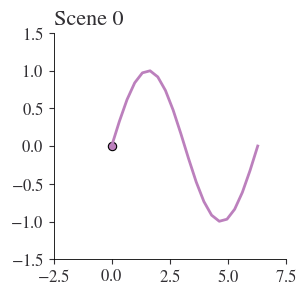

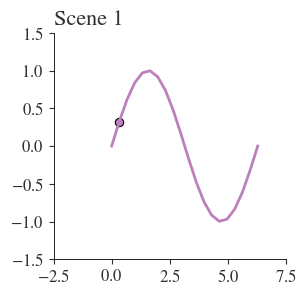

In [2]:
def plot_scene(i):
    fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
    # Create an array
    x = np.linspace(0, 2*np.pi, 20)
    # Create the y function
    y = np.sin(x)
    ax.plot(x, y)
    ax.scatter([x[i]], [y[i]])
    ax.set_title(f"Scene {i}")

plot_scene(0)
plot_scene(1)

Okay, so that's the basic idea: a function of the scene that we can move forward through time. Later, we'll stitch together the independent images. For now, let's turn back to the gapminder data.

The gapminder data are from the excellent [Our World in Data](https://ourworldindata.org/) website, but they've been filtered a bit for this book. Let's load them up:

In [3]:
df = pd.read_csv("https://github.com/aeturrell/coding-for-economists/raw/main/data/owid_gapminder.csv")
df.head()

URLError: <urlopen error no host given>

Brilliant, that's our data. But now we need a plot, with a few dimensions of data, and a way to progress that plot through time.

Let's first setup the end phase of our plot, where we'll eventually get to. This will be based on the final year in the data.

There are five dimensions displayed in the plot we're recreating:

- continent, via colour
- income (GDP per capita), on the x-axis
- life expectancy, on the y-axis
- population, as bubble size
- year, as the time dimension

We have almost all of those columns already, but we do need to convert the list of *continents* to a list of *colours*. **matplotlib** has a built-in colour cycler, that we can use for this purpose. It is accessed via `plt.rcParams['axes.prop_cycle'].by_key()['color']`. To map the continents into colours, we'll use a dictionary combined with the `zip` function that 'zips' two lists together (if the lists are unequal it takes the shorter and as there are only five continents in our data but ten colours, this will happen).

In [ ]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [ ]:
colour_mapping = dict(zip(df["Continent"].unique(),
                          plt.rcParams['axes.prop_cycle'].by_key()['color']))
df["colour"] = df["Continent"].map(colour_mapping)
df.head()

Okay, so we have all we need for our plot! Now we need to make a function that plots this when passed an index that gets mapped into a year. Note that while we have every year of data here, that may not be true in general so it's always safer to map an index to the years that *are* available using a dictionary like so:

In [ ]:
step_to_yr_map = dict(zip(range(len(df["Year"].unique())),
                          df["Year"].unique()))

In [ ]:
def gapminder_at_year(i, gap_df):
    """ Plots the gapminder data for a given step
    """
    if(type(i) != int):
        return ValueError("i must be an integer.")
    # Map steps into years
    step_to_yr_map = dict(zip(range(len(gap_df["Year"].unique())),
                              gap_df["Year"].unique()))
    if(i not in step_to_yr_map.keys()):
        return ValueError("i is beyond range of number of years.")
    # Filtered version of data with only the relevant year
    gdf_yr = gap_df[gap_df["Year"] == step_to_yr_map[i]]
    plt.close('all')
    fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
    ax.scatter(x=gdf_yr["GDP per capita"]/1e3, y=gdf_yr["Life expectancy"],
               c=gdf_yr["colour"], s=gdf_yr["Population"]/1e6,
               alpha=0.8, edgecolor='k')
    ax.set_xlim(0, 100)
    ax.set_ylim(20, gap_df["Life expectancy"].max()*1.2)
    ax.set_xlabel("GDP per capita (1000s 2011 USD)")
    ax.set_ylabel("Life expectancy (years)")
    ax.set_title(f"Gapminder: {step_to_yr_map[i]}")
    plt.show()

# Test this out at the first step
gapminder_at_year(0, df)

We now have everything we need to create the individual scenes in our animation.

## Creating Animations Using the **Gif** Package

The [**gif**](https://github.com/maxhumber/gif) package is here to make it as easy as possible to create gifs from a series of plot images created using **matplotlib**, **altair**, or **plotly**. (In principle, this should also work for **plotnine** as it's built on top of **matplotlib**). To install it, use `pip install gif` on the command line.

**gif** works by using function decorators (you can learn more about these in the advanced coding chapter). These 'decorate' existing functions using an `@` symbol and change their behaviour. In this case, the decorator is `@git.frame` and it tells **gif** to remember this function as one frame of a gif.

Note that in the example below, we'll make things a bit less high resolution and brief than we might optimally do, just to save on some file space.

A few tips:

- use a high resolution when creating the gif, as high as 900 dots per inch. In the below we use a quite large 400 dots per inch to save a bit of space but it still gives a hefty file size. However...
- ...you can use an optimizer to then shrink that finished high res gif down to a more respectable size. In the below, [**pygifsicle**](https://github.com/LucaCappelletti94/pygifsicle) is used to do this, a package that you will need to install separately. In our example, this takes the gif down to under 1MB.
- repeate the last frame multiple times; it allows the viewer to see where your animation ended up and gives a break before looping around again.



```python
import gif

@gif.frame
def gapminder_at_year(i, gap_df):
    """ Plots the gapminder data for a given step
    """
    if(type(i) != int):
        return ValueError("i must be an integer.")
    # Map steps into years
    step_to_yr_map = dict(zip(range(len(gap_df["Year"].unique())),
                              gap_df["Year"].unique()))
    if(i not in step_to_yr_map.keys()):
        return ValueError("i is beyond range of number of years.")
    gdf_yr = gap_df[gap_df["Year"] == step_to_yr_map[i]]
    plt.close('all')
    fig, ax = plt.subplots(figsize=(4, 3), dpi=400)
    ax.scatter(x=gdf_yr["GDP per capita"]/1e3, y=gdf_yr["Life expectancy"],
               c=gdf_yr["colour"], s=gdf_yr["Population"]/1e6,
               alpha=0.8, edgecolor='k')
    ax.set_xlim(0, 100)
    ax.set_ylim(20, gap_df["Life expectancy"].max()*1.2)
    ax.set_xlabel("GDP per capita (1000s 2011 USD)")
    ax.set_ylabel("Life expectancy (years)")
    ax.set_title(f"Gapminder: {step_to_yr_map[i]}")
    plt.tight_layout()

# How many iterations do we want?
total_num_years = len(df["Year"].unique())
# Produce the frames. Here, I'll only do the last 20 years to make the gif small
frames = [gapminder_at_year(i, df) for i in range(total_num_years-20, total_num_years)]
# A trick: repeat the last frame a few more times to let people see where the animation ends
frames = frames + [gapminder_at_year(total_num_years-1, df) for i in range(10)]
# Save the animation
gif.save(frames, Path("img/gapminder.gif"), duration=200, unit="ms", between="frames")
# Optimize the animation to make it smaller (and therefore easier to share)
from pygifsicle import optimize
optimize(Path("img/gapminder.gif"))
```

![Gif of shortened gapminder sequence.](https://github.com/aeturrell/coding-for-economists/raw/main/img/gapminder.gif)

And there we have a (shortened and not-as-high-res-as-optimally) gapminder sequence! Can you spot the financial crisis?

A higher resolution run would smooth out that slightly roughened text. Now you've seen how it works, you can really run quite free with animations because, if you can draw it as a series of frames with matplotlib (and related libraries), plotly, or altair, you can animate it.


```{admonition} Exercises
1. Animate the bead on a sine curve we saw earlier using the **gif** package.
2. Animate the complete gapminder sequence, from first year of data to 2018.
```

## Making Animations Using the **imagio** Package

[**imagio**](https://imageio.readthedocs.io/en/stable/) is an alternative package for making animations, and works in a slightly different way, with an intermediate step between creating the static images and weaving them into a video. However, it allows you to stitch together jpg files as well as png files.

Let's imagine that you have a folder for temporary files called 'scratch' and a directory for finished gifs called 'img'. The code below gives an example of how you would use **imageio** to create 20 frames of a video and then weave them together into a .gif:

```python
import imageio


def frame(i):
    plt.close('all')
    x = np.linspace(0, 2*np.pi, 20)
    y = np.sin(x)
    fig, ax = plt.subplots(figsize=(2, 2), dpi=900)
    ax.plot(x, y, zorder=1, lw=0.5)
    ax.scatter([x[i]], [y[i]], zorder=2)
    ax.set_title(f"Scene {i}")
    # Outputs files of name "frame000.png" etc., but you could use .jpg
    plt.savefig(Path(f'scratch/frame{i:0>3d}.png'))

# Create the frames; this creates files within the 'scratch' directory
[frame(i) for i in range(20)]

file_names = list(Path("scratch").glob("*.png"))
file_names.sort()

# Now create the gif in the img directory:
writer = imageio.get_writer(Path("img/sin_bead.gif"), mode="I", fps=4)
for img_file in file_names:
    image = imageio.imread(img_file)
    writer.append_data(image)

from pygifsicle import optimize
optimize(Path("img/sin_bead.gif"))
```

![Gif of point on sine curve made with imagio](https://github.com/aeturrell/coding-for-economists/raw/main/img/sin_bead.gif)

**imagio** can also write to .mp4 files if needed, and has a host of other features not covered here.

## See Also

There are some excellent other tools out there. The command line tool [**ffmpeg**](https://www.ffmpeg.org/) is worth a look if you need fancier video options than are provided by the two tools we've met.

[**Matplotlib**](https://matplotlib.org/stable/api/animation_api.html) has a built-in animation feature too, though historically it has been a bit more tricky to use than tools like **imagio** or **gif**.

[**ahlive**](https://ahlive.readthedocs.io/en/latest) is a really promising package that is still in early development. It integrates directly with **pandas** and has some easy-to-use features for making sophisticated looking animations in just a few lines of code.

Finally, the master of animation in Python-but with a *very* steep learning curve-is [**manim**](https://3b1b.github.io/manim/index.html), which makes extremely professional-looking mathematical animations. As an example, take a look at [this video on Fourier Series](https://www.youtube.com/watch?v=r6sGWTCMz2k&ab_channel=3Blue1Brown) that was created with **manim**.